In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

TRAIN_PATH = "/content/drive/MyDrive/StackOverflow_Data/new/split_90-10/train.csv"
TEST_PATH = "/content/drive/MyDrive/StackOverflow_Data/new/split_90-10/test.csv"

train_df = pd.read_csv(TRAIN_PATH, nrows=300_000)
test_df  = pd.read_csv(TEST_PATH, nrows=50_000)

print(train_df.shape)
print(test_df.shape)


(300000, 17)
(50000, 17)


In [ ]:
print(train_df.columns)


Index(['Id', 'text', 'android', 'c#', 'c++', 'css', 'html', 'java',
       'javascript', 'node.js', 'pandas', 'php', 'python', 'python-3.x', 'r',
       'reactjs', 'sql'],
      dtype='object')


In [ ]:
# kolom label
label_cols = [
    'android', 'c#', 'c++', 'css', 'html', 'java', 'javascript',
    'node.js', 'pandas', 'php', 'python', 'python-3.x',
    'r', 'reactjs', 'sql'
]

# X (teks)
X_train_text = train_df['text']
X_test_text  = test_df['text']

# Y (label multi-label)
y_train = train_df[label_cols].values
y_test  = test_df[label_cols].values

print(X_train_text.shape)
print(y_train.shape)


(300000,)
(300000, 15)


#TF-IDF (Tokenisasi SVM)

In [ ]:
# Teks dibersihkan
train_df['text'] = train_df['text'].fillna("").astype(str)
test_df['text']  = test_df['text'].fillna("").astype(str)

X_train_text = train_df['text']
X_test_text  = test_df['text']

print(
    train_df['text'].isna().sum(),
    test_df['text'].isna().sum()
)

0 0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,   # aman & cukup
    ngram_range=(1,2),
    stop_words="english"
)

X_train = tfidf.fit_transform(X_train_text)
X_test  = tfidf.transform(X_test_text)

print(X_train.shape)
print(X_test.shape)


(300000, 10000)
(50000, 10000)


#Training SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm = OneVsRestClassifier(
    LinearSVC(class_weight="balanced")
)

svm.fit(X_train, y_train)

print("SVM training selesai")


SVM training selesai


#Evaluasi

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    hamming_loss,
    accuracy_score
)

# prediksi
y_pred = svm.predict(X_test)

# ===== MICRO =====
precision_micro = precision_score(y_test, y_pred, average="micro")
recall_micro    = recall_score(y_test, y_pred, average="micro")
f1_micro        = f1_score(y_test, y_pred, average="micro")

# ===== MACRO =====
precision_macro = precision_score(y_test, y_pred, average="macro")
recall_macro    = recall_score(y_test, y_pred, average="macro")
f1_macro        = f1_score(y_test, y_pred, average="macro")

# ===== LAINNYA =====
hamming = hamming_loss(y_test, y_pred)
subset  = accuracy_score(y_test, y_pred)

print("=== MICRO AVERAGE ===")
print("Precision :", precision_micro)
print("Recall    :", recall_micro)
print("F1-score  :", f1_micro)

print("\n=== MACRO AVERAGE ===")
print("Precision :", precision_macro)
print("Recall    :", recall_macro)
print("F1-score  :", f1_macro)

print("\n=== OTHER METRICS ===")
print("Hamming Loss :", hamming)
print("Subset Accuracy :", subset)


=== MICRO AVERAGE ===
Precision : 0.596903460837887
Recall    : 0.9093268477409245
F1-score  : 0.7207136111362666

=== MACRO AVERAGE ===
Precision : 0.607213966733117
Recall    : 0.8996518560706338
F1-score  : 0.711934057983928

=== OTHER METRICS ===
Hamming Loss : 0.057568
Subset Accuracy : 0.41388


In [ ]:
import joblib

joblib.dump(svm, "/content/drive/MyDrive/SVM/svm_model.pkl")
joblib.dump(tfidf, "/content/drive/MyDrive/SVM/tfidf.pkl")

print("Model dan TF-IDF berhasil disimpan")


Model dan TF-IDF berhasil disimpan


In [ ]:
svm_loaded = joblib.load("/content/drive/MyDrive/SVM/svm_model.pkl")
tfidf_loaded = joblib.load("/content/drive/MyDrive/SVM/tfidf.pkl")

y_pred_test = svm_loaded.predict(tfidf_loaded.transform(X_test_text))


#Visualisasi

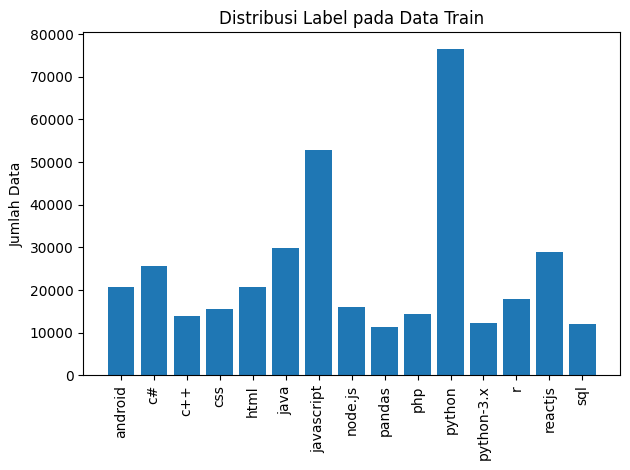

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

label_counts = y_train.sum(axis=0)

plt.figure()
plt.bar(range(len(label_counts)), label_counts)
plt.xticks(range(len(label_cols)), label_cols, rotation=90)
plt.title("Distribusi Label pada Data Train")
plt.ylabel("Jumlah Data")
plt.tight_layout()
plt.show()


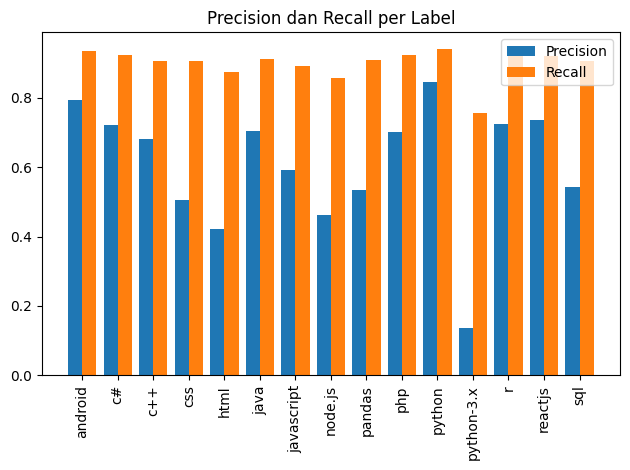

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_per_label = precision_score(
    y_test, y_pred, average=None
)
recall_per_label = recall_score(
    y_test, y_pred, average=None
)

x = np.arange(len(label_cols))

plt.figure()
plt.bar(x - 0.2, precision_per_label, width=0.4, label="Precision")
plt.bar(x + 0.2, recall_per_label, width=0.4, label="Recall")
plt.xticks(x, label_cols, rotation=90)
plt.legend()
plt.title("Precision dan Recall per Label")
plt.tight_layout()
plt.show()


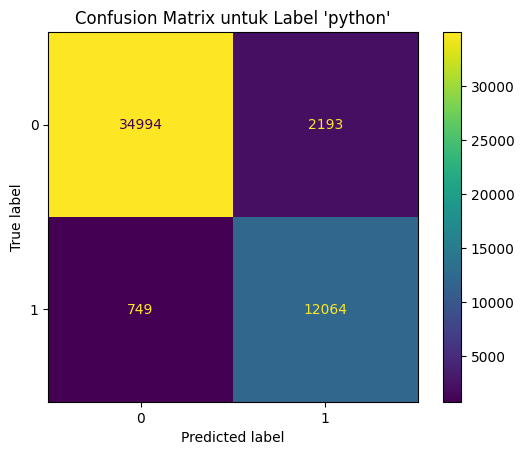

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_index = label_cols.index("python")

cm = confusion_matrix(
    y_test[:, label_index],
    y_pred[:, label_index]
)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix untuk Label 'python'")
plt.show()


#Perbandingan

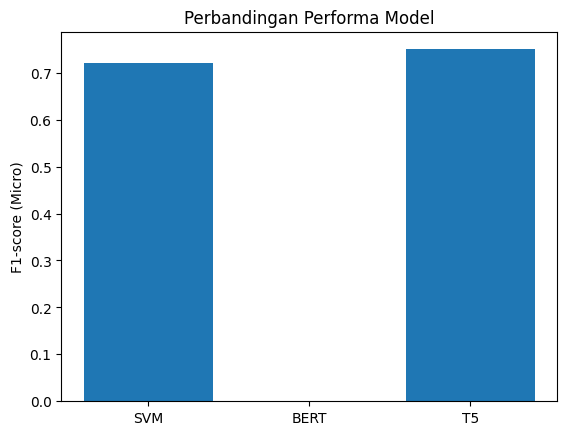

In [ ]:
models = ["SVM", "BERT", "T5"]
f1_scores = [0.72, 0.00, 0.75]  # contoh

plt.figure()
plt.bar(models, f1_scores)
plt.ylabel("F1-score (Micro)")
plt.title("Perbandingan Performa Model")
plt.show()
